In [1]:
import pandas as pd
import numpy as np
import joblib
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
from imblearn.over_sampling import SMOTE


In [2]:
df_custom = pd.read_csv("../datasets/processed_data/combined_dataset.csv")
df_wesad = pd.read_csv("../datasets/processed_data/wesad_hr_baseline_stress.csv")


print("LENGTH CUSTOM", len(df_custom))
print("LENGTH WESAD", len(df_wesad))

LENGTH CUSTOM 1259
LENGTH WESAD 45004


In [3]:
print("CUSTOM:", df_custom["stress"].unique())

print("WESAD:", df_wesad["label"].unique())

CUSTOM: [2 1 3 4 0]
WESAD: [1 4 3 2]


In [4]:
custom_label_map = {
    1: 0,  # Baseline
    2: 1,  # Mild Stress
    3: 0,  # Amusement → Baseline-like
    4: 2   # High Stress
}
df_custom = df_custom[df_custom['stress'].isin(custom_label_map)]
df_custom['stress'] = df_custom['stress'].map(custom_label_map)

In [5]:
wesad_label_map = {
    1: 0,  # Baseline
    2: 2,  # Stress → High Stress
    3: 0,  # Amusement → Baseline-like
    4: 1   # Meditation → Mild Stress
}
df_wesad = df_wesad[df_wesad['label'].isin(wesad_label_map)]
df_wesad['label'] = df_wesad['label'].map(wesad_label_map)

In [6]:
print("CUSTOM:", df_custom["stress"].unique())

print("WESAD:", df_wesad["label"].unique())

CUSTOM: [1 0 2]
WESAD: [0 1 2]


In [7]:
# Group by stress and get blink stats from custom data
blink_stats = df_custom.groupby('stress')['BKPMIN'].agg(['mean', 'std', 'min', 'max'])
print(blink_stats)

             mean       std  min   max
stress                                
0       11.231729  6.213447  0.0  34.0
1       11.049528  6.370729  0.0  40.0
2       11.729167  5.495413  1.0  36.0


In [8]:
# Custom
df_custom = df_custom[['BPM', 'BKPMIN', 'stress']]
df_custom.columns = ['hr', 'blink', 'label']

# WESAD (no blink data)
df_wesad = df_wesad[['bpm', 'label']]
df_wesad['blink'] = 0  # fill with zero
df_wesad.columns = ['hr', 'label', 'blink']
df_wesad = df_wesad[['hr', 'blink', 'label']]

In [9]:
def generate_blink_wesad(label):
    # Map WESAD labels to your custom stress classes
    mapping = {1: 0, 2: 2, 3: 1, 4: 3}  # 4->0 since meditation likely low blink
    custom_stress = mapping.get(label, 0)

    mean_blink = blink_stats.loc[custom_stress, 'mean']
    std_blink = blink_stats.loc[custom_stress, 'std']

    # Shift mean for stress class (custom_stress == 2) to reflect literature (e.g., +15)
    if custom_stress == 2:
        mean_blink += 15  # stress blink boost from literature (approximate)

    # Sample blink from normal distribution, clip to plausible range
    blink = np.random.normal(mean_blink, std_blink)
    blink = np.clip(blink, 5, 50)
    return int(round(blink))

df_wesad['blink'] = df_wesad['label'].apply(generate_blink_wesad)


In [10]:
def simulate_yawn(row):
    # Expected yawns per hour based on label
    if row['label'] == 0:       # Baseline
        base_rate = 2
    elif row['label'] == 1:     # Mild stress
        base_rate = 5
    elif row['label'] == 2:     # High stress
        base_rate = 12
    else:
        return np.nan
    
    # Convert to expected yawns per minute (fractional)
    yawns_per_min = base_rate / 60.0
    
    # Simulate fractional yawn count for this minute using Poisson around expected rate
    # Poisson lambda = yawns_per_min, but small lambda can produce mostly 0 or 1
    simulated = np.random.poisson(yawns_per_min)
    
    # Clip to reasonable max (e.g., 1 yawn per minute max)
    simulated = np.clip(simulated, 0, 1)
    
    return simulated

# Apply to both datasets
df_wesad['yawn'] = df_wesad.apply(simulate_yawn, axis=1)
df_custom['yawn'] = df_custom.apply(simulate_yawn, axis=1)

# Optional smoothing: rolling mean over 3 minutes for smoothing temporal variation
df_wesad['yawn'] = df_wesad['yawn'].rolling(window=3, min_periods=1, center=True).mean()
df_custom['yawn'] = df_custom['yawn'].rolling(window=3, min_periods=1, center=True).mean()

In [11]:
df = pd.concat([df_custom, df_wesad], ignore_index=True)

In [12]:
print("WESAD class counts:")
print(df_wesad['label'].value_counts())

print("\nCustom class counts:")
print(df_custom['label'].value_counts())

WESAD class counts:
label
0    23237
1    11786
2     9981
Name: count, dtype: int64

Custom class counts:
label
0    578
1    431
2    102
Name: count, dtype: int64


In [13]:
X = df[['hr', 'blink', 'yawn']]
y = df['label']

# Split the data with stratification to maintain label proportions
X_train, X_test, y_train, y_test = train_test_split(
    X, y, stratify=y, test_size=0.2, random_state=42
)

# Fill missing values using training set mean (to avoid data leakage)
X_train = X_train.fillna(X_train.mean())
X_test = X_test.fillna(X_train.mean())  # Use train mean, not test mean

# Feature scaling
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Apply SMOTE after scaling
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_train_scaled, y_train)

/Users/birajkhanal/Developer/Personal/College/machine_learning/StressFusion-RT/venv/lib/python3.9/site-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(


In [14]:
clf = RandomForestClassifier(class_weight='balanced', random_state=42)
clf.fit(X_train, y_train)

param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [5, 10, 15, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'bootstrap': [True, False]
}
rf = RandomForestClassifier(random_state=42, class_weight='balanced')

grid_search = GridSearchCV(
    estimator=rf,
    param_grid=param_grid,
    cv=5,
    n_jobs=-1,
    verbose=2,
    scoring='accuracy'
)

grid_search.fit(X_train, y_train)


Fitting 5 folds for each of 216 candidates, totalling 1080 fits
[CV] END bootstrap=True, max_depth=5, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.6s
[CV] END bootstrap=True, max_depth=5, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.6s
[CV] END bootstrap=True, max_depth=5, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.6s
[CV] END bootstrap=True, max_depth=5, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.6s
[CV] END bootstrap=True, max_depth=5, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.6s
[CV] END bootstrap=True, max_depth=5, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time=   1.1s
[CV] END bootstrap=True, max_depth=5, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time=   1.1s
[CV] END bootstrap=True, max_depth=5, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time=   1.1s
[CV] END

GridSearchCV(cv=5,
             estimator=RandomForestClassifier(class_weight='balanced',
                                              random_state=42),
             n_jobs=-1,
             param_grid={'bootstrap': [True, False],
                         'max_depth': [5, 10, 15, None],
                         'min_samples_leaf': [1, 2, 4],
                         'min_samples_split': [2, 5, 10],
                         'n_estimators': [100, 200, 300]},
             scoring='accuracy', verbose=2)

Best parameters: {'bootstrap': True, 'max_depth': 5, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 300}
              precision    recall  f1-score   support

           0      0.676     0.840     0.749      4763
           1      0.502     0.206     0.292      2443
           2      0.784     0.896     0.836      2017

    accuracy                          0.684      9223
   macro avg      0.654     0.647     0.626      9223
weighted avg      0.653     0.684     0.647      9223



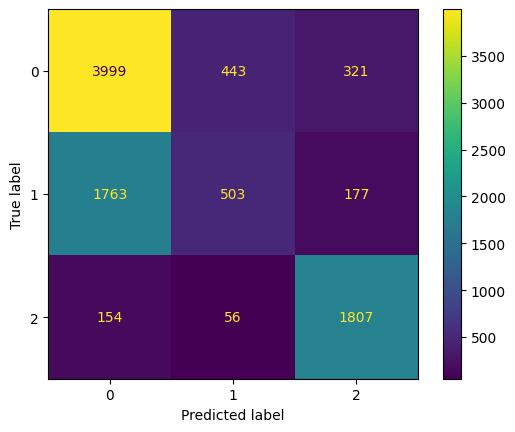

[1]


/Users/birajkhanal/Developer/Personal/College/machine_learning/StressFusion-RT/venv/lib/python3.9/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


In [ ]:
best_model = grid_search.best_estimator_

y_pred = best_model.predict(X_test)

print("Best parameters:", grid_search.best_params_)

print(classification_report(y_test, y_pred, digits=3))
ConfusionMatrixDisplay.from_predictions(y_test, y_pred)
plt.grid(False)
plt.show()

In [16]:
importances = best_model.feature_importances_
feature_names = X_train.columns

# Create a DataFrame for visualization
feat_imp_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)

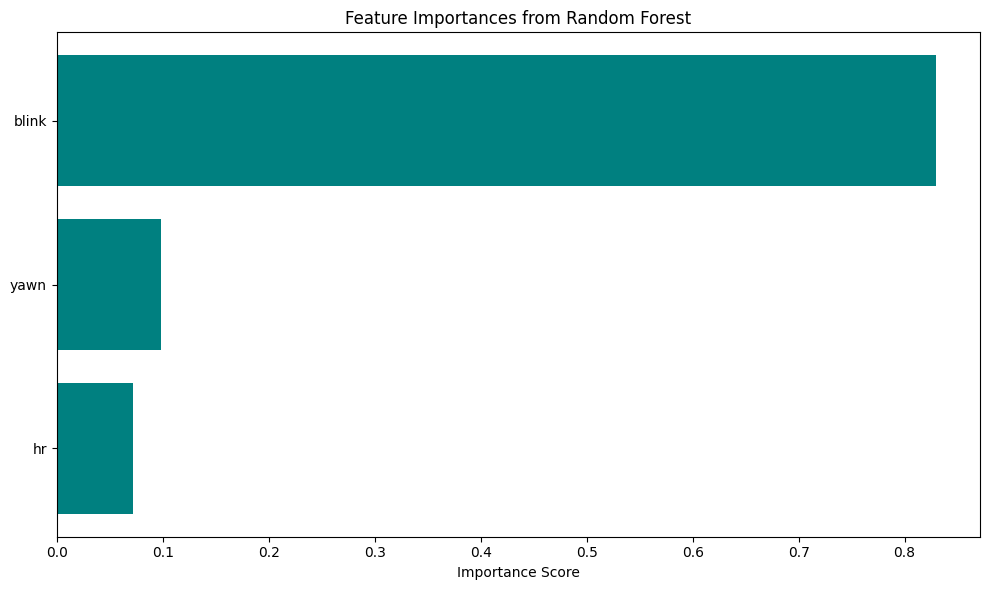

In [17]:
plt.figure(figsize=(10, 6))
plt.barh(feat_imp_df['Feature'], feat_imp_df['Importance'], color='teal')
plt.gca().invert_yaxis()  # Most important on top
plt.title("Feature Importances from Random Forest")
plt.xlabel("Importance Score")
plt.tight_layout()
plt.show()


In [18]:
joblib.dump(best_model, '../models/stress_model.pkl')

['../models/stress_model.pkl']